In [1]:
from pint.logging import setup as setup_log

from enterprise.pulsar import Pulsar
from enterprise.signals.signal_base import PTA
from enterprise.signals.white_signals import MeasurementNoise
from enterprise.signals.gp_signals import MarginalizingTimingModel
from enterprise_extensions.blocks import red_noise_block, dm_noise_block

from PTMCMCSampler.PTMCMCSampler import PTSampler

import numpy as np
import corner
import matplotlib.pyplot as plt

/home/abhimanyu/miniconda3/envs/pint-noise/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


Optional mpi4py package is not installed.  MPI support is not available.


In [2]:
setup_log(level="WARNING")

1

WARNING  (pint.logging                  ): /home/abhimanyu/miniconda3/envs/pint-noise/lib/python3.9/site-packages/enterprise/signals/parameter.py:62 RuntimeWarning: divide by zero encountered in log


In [3]:
psr = Pulsar("sim5.par", "sim5.tim", timing_package="pint")

In [5]:
tm = MarginalizingTimingModel()
wn = MeasurementNoise(efac=1)
arn = red_noise_block(components=5)
dmn = dm_noise_block(components=25)

In [6]:
signal = tm + wn + dmn + arn

In [7]:
pta = PTA([signal(psr)])

In [8]:
pta.param_names

['SIM5_dm_gp_gamma',
 'SIM5_dm_gp_log10_A',
 'SIM5_red_noise_gamma',
 'SIM5_red_noise_log10_A']

In [9]:
ndim = len(pta.param_names)
x0 = np.array([p.sample() for p in pta.params])
cov = np.diag(np.ones(ndim)) * 1e-4
outdir = "chains/"
Niter = 100000

In [10]:
sampler = PTSampler(
    ndim,
    pta.get_lnlikelihood,
    pta.get_lnprior,
    cov,
    outDir=outdir,
)

In [11]:
sampler.sample(
    x0,
    Niter,
)

Finished 10.00 percent in 2.342907 s Acceptance rate = 0.24864Adding DE jump with weight 20
Finished 100.00 percent in 22.623832 s Acceptance rate = 0.25971
Run Complete


In [14]:
chain = np.genfromtxt(f"{outdir}/chain_1.txt")
burn = chain.shape[0]//5
burned_chain = chain[burn:, :-4]
burned_chain[:, 1] = 10**burned_chain[:, 1] * 1e6

In [15]:
np.argmax(chain[:,-4])

3693

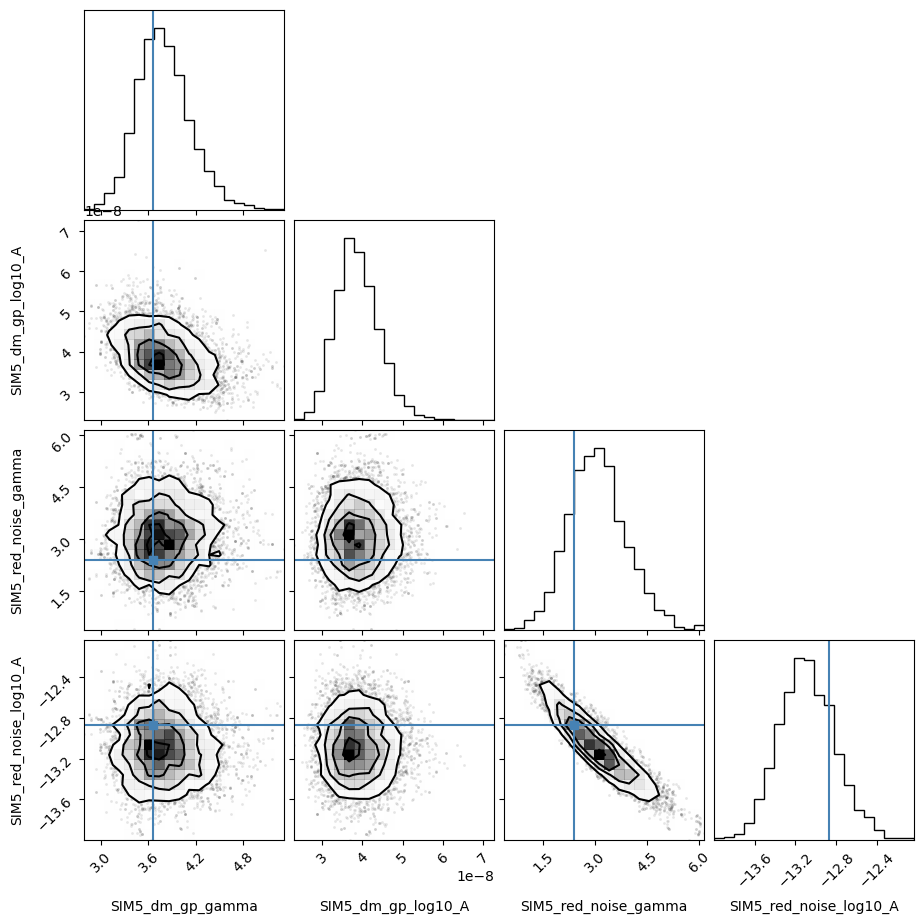

In [16]:
fig = corner.corner(
    burned_chain, 
    labels=pta.param_names, 
    truths=chain[775][:-4],
)